In [68]:
import pandas as pd
import numpy as np
import csv
import seaborn as sns
import copy
from scipy import stats
from sklearn.metrics import f1_score
import pyspark
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
#import the csv data file
data = pd.read_csv("LiveStream-1-Cam-2-New-NL.csv")

In [70]:
data

,Date,Time,Timer,Temperature,Condition,Light,Car,CarDuration
0,2022-06-26,06-58-11.741,45.0,14.97,mist,Red,False,2
1,2022-06-26,06-58-18.254,8.0,14.97,mist,Green,False,0
2,2022-06-26,06-59-26.896,66.0,15.05,mist,Red,False,0
3,2022-06-26,06-59-35.205,7.0,15.05,mist,Green,False,1
4,2022-06-26,07-00-39.761,63.0,15.05,mist,Red,False,0
...,...,...,...,...,...,...,...,...
2173,2022-06-29,01-30-14.859,7.0,16.95,few clouds,Green,False,2
2174,2022-06-29,01-36-36.451,382.0,16.83,scattered clouds,Red,True,3
2175,2022-06-29,01-36-42.591,4.0,16.83,scattered clouds,Green,False,1
2176,2022-06-29,01-36-42.821,1.0,16.83,scattered clouds,Red,False,0


In [71]:
#copy the dataframe to a new dataframe in order to do some processing
newDf = data[['Timer','Car','CarDuration','Temperature', 'Condition','Light']].copy()

[Text(0, 0.5, 'Count')]

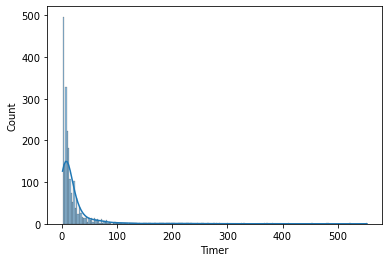

In [72]:
#timer distribution in the dataset
ax = sns.histplot(newDf['Timer'], kde=True)
ax.set( ylabel='Count')

In [73]:
#outlier detection and elimination using IQR

percentile25 = newDf['Timer'].quantile(0.25)
percentile75 = newDf['Timer'].quantile(0.75)
iqr = percentile75 - percentile25

#select upper limit and showcase potential outliers
upperLimit = percentile75 + 1.5*iqr
lowerLimit = 4
newDfOut1 = newDf[newDf['Timer'] < upperLimit]
newDfOut1.drop(newDfOut1[newDfOut1['Timer'] < lowerLimit].index, inplace = True)

C:\Users\ronan\anaconda3\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [74]:
newDfOut1

,Timer,Car,CarDuration,Temperature,Condition,Light
1,8.0,False,0,14.97,mist,Green
3,7.0,False,1,15.05,mist,Green
5,5.0,False,1,15.05,mist,Green
7,6.0,False,1,15.11,overcast clouds,Green
8,32.0,False,1,15.11,overcast clouds,Red
...,...,...,...,...,...,...
2165,5.0,False,0,17.14,few clouds,Green
2167,5.0,False,2,17.14,few clouds,Green
2171,6.0,False,0,17.07,few clouds,Green
2173,7.0,False,2,16.95,few clouds,Green


[Text(0, 0.5, 'Count')]

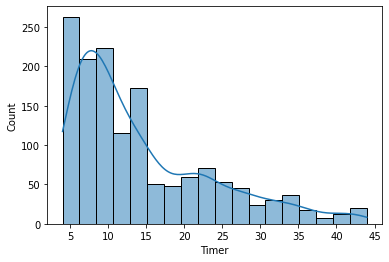

In [75]:
#new timer distribution in the dataset
ax = sns.histplot(newDfOut1['Timer'], kde=True)
ax.set( ylabel='Count')

In [76]:
#encoding the values
le = LabelEncoder()
newDfOut1['Light'] = le.fit_transform(newDfOut1['Light'])
newDfOut1['Car'] = le.fit_transform(newDfOut1['Car'])
newDfOut1['Condition'] = le.fit_transform(newDfOut1['Condition'])

<ipython-input-76-1b38571168fd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newDfOut1['Light'] = le.fit_transform(newDfOut1['Light'])
<ipython-input-76-1b38571168fd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newDfOut1['Car'] = le.fit_transform(newDfOut1['Car'])
<ipython-input-76-1b38571168fd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [77]:
newDfOut1

,Timer,Car,CarDuration,Temperature,Condition,Light
1,8.0,0,0,14.97,4,0
3,7.0,0,1,15.05,4,0
5,5.0,0,1,15.05,4,0
7,6.0,0,1,15.11,5,0
8,32.0,0,1,15.11,5,1
...,...,...,...,...,...,...
2165,5.0,0,0,17.14,2,0
2167,5.0,0,2,17.14,2,0
2171,6.0,0,0,17.07,2,0
2173,7.0,0,2,16.95,2,0


In [99]:
#generating data for "pastCounter" seconds in the future light flip
carDurT = 0
pastCounter = 3

#creating a new dataframe to hold this new data
newDfOut = pd.DataFrame(columns = ['Timer', 'Car', 'CarDuration', 'Temperature', 'Condition', 'Light', 'LightFuture'])

#every row of data will generate X rows of new data, with X being the timer a signal was a certain color
for i in range(len(newDfOut1)):
    #grab the current values of a row
    cols = newDfOut1.iloc[i]
    light, timer, carDuration, temperature, condition, car = int(cols['Light']), cols['Timer'], cols['CarDuration'], cols['Temperature'], cols['Condition'], cols['Car']
    
    #carDurT is a counter to know at which point in the new generated rows will a car be waiting and for how long
    carDurT = timer-carDuration
    carDuration = 0
    car = 0
    
    #the for loops and if statements are the simple logic of propogating and filling in the new rows
    for j in range(1,int(timer)+1):
        if carDurT <=0:
            carDuration = abs(carDurT)+1
        if carDuration > 0:
            car = 1
        if j >= (timer-(pastCounter-1)):
            if light == 1:
                lightT = 0
            else:
                lightT = 1
            newDfOut = newDfOut.append({'Timer': j, 'Car': car, 'CarDuration': carDuration, 'Temperature': temperature, 'Condition': condition, 'Light': light,  'LightFuture': lightT}, ignore_index = True)
        else:   
            newDfOut = newDfOut.append({'Timer': j, 'Car': car, 'CarDuration': carDuration, 'Temperature': temperature, 'Condition': condition, 'Light': light,  'LightFuture': light}, ignore_index = True)
        carDurT = carDurT - 1
    carDurT = 0

In [138]:
newDfOut.iloc[0:10]

,Timer,Car,CarDuration,Temperature,Condition,Light,LightFuture
0,1.0,0.0,0.0,14.97,4.0,0.0,0.0
1,2.0,0.0,0.0,14.97,4.0,0.0,0.0
2,3.0,0.0,0.0,14.97,4.0,0.0,0.0
3,4.0,0.0,0.0,14.97,4.0,0.0,0.0
4,5.0,0.0,0.0,14.97,4.0,0.0,0.0
5,6.0,0.0,0.0,14.97,4.0,0.0,1.0
6,7.0,0.0,0.0,14.97,4.0,0.0,1.0
7,8.0,0.0,0.0,14.97,4.0,0.0,1.0
8,1.0,0.0,0.0,15.05,4.0,0.0,0.0
9,2.0,0.0,0.0,15.05,4.0,0.0,0.0


In [102]:
#splitting the dataset into features and target
feature_cols = list(newDfOut.columns[:-1])
target_col = newDfOut.columns[-1]

X_all = newDfOut[feature_cols]
Y_all = newDfOut[target_col]

#split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_all, Y_all, test_size=0.33, random_state=43)

In [103]:
target_col

'LightFuture'

In [104]:
#gridsearching
param_grid = [{'C': 10**np.linspace(-3,3,20)}]
lin_reg = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
logreg = GridSearchCV(lin_reg, param_grid, cv=10, scoring='accuracy', 
                             refit=True)
#training a logistic regression model
logreg.fit(X_train,y_train)

#predicting
y_pred=logreg.best_estimator_.predict(X_test)

In [105]:
#evaluating the performance of the model
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
print('Recall: ',metrics.recall_score(y_test, y_pred, zero_division=1))
print('Precision:',metrics.precision_score(y_test, y_pred, zero_division=1))
print('F1:',metrics.f1_score(y_test, y_pred, zero_division=1))
print('CL Report:',metrics.classification_report(y_test, y_pred, zero_division=1))

Accuracy:  0.8149646107178968
Recall:  0.8624444444444445
Precision: 0.8542813119084306
F1: 0.8583434700873604
CL Report:               precision    recall  f1-score   support

         0.0       0.74      0.73      0.73      2423
         1.0       0.85      0.86      0.86      4500

    accuracy                           0.81      6923
   macro avg       0.80      0.79      0.80      6923
weighted avg       0.81      0.81      0.81      6923



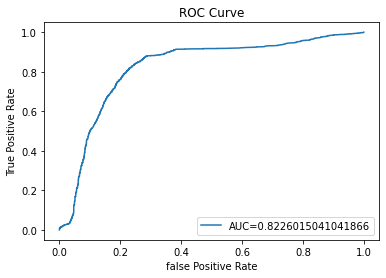

In [106]:
#ROC curve calculation

y_pred_proba= logreg.best_estimator_.predict_proba(X_test) [::,1]

false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)

auc= metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

In [107]:
#training a decision tree classifier
my_random_seed = 45

tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

model = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=5)

model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150]})

In [108]:
#decision tree prediction
y_predict = model.best_estimator_.predict(X_test)

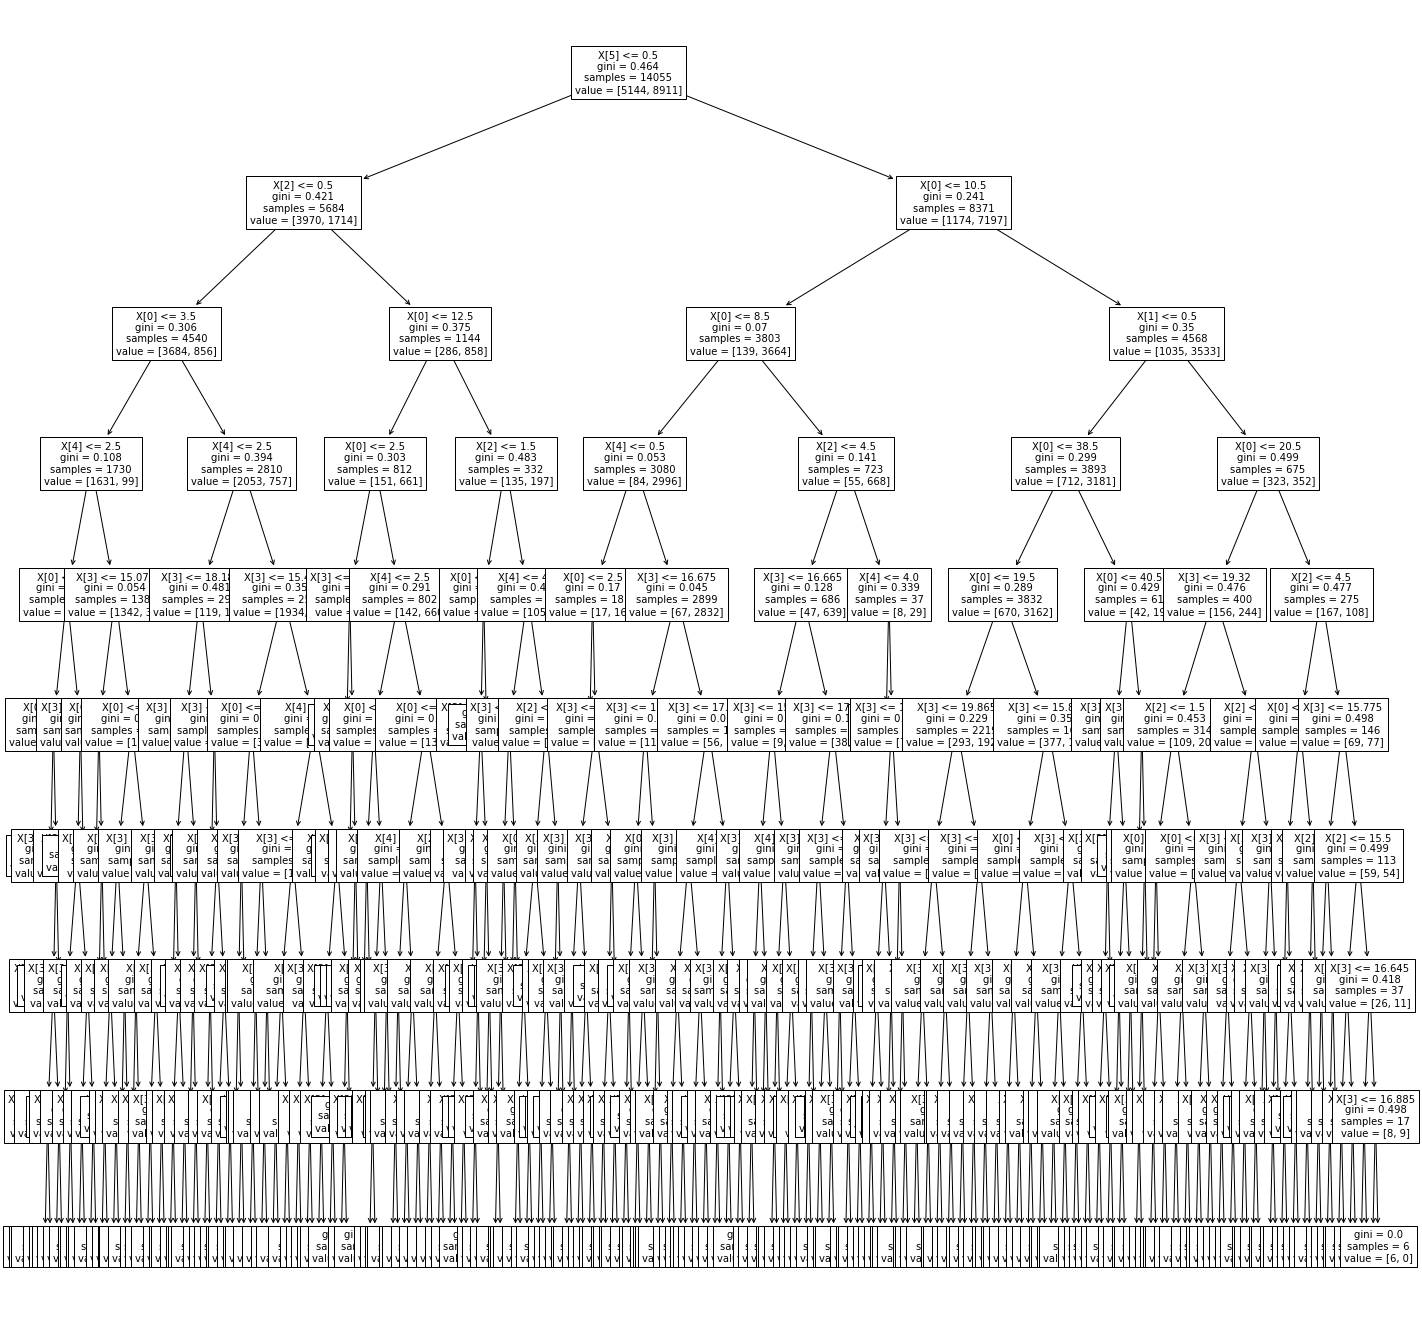

In [109]:
#visualizing the tree
plt.figure(figsize=(24,24))  # set plot size (denoted in inches)
tree.plot_tree(model.best_estimator_, fontsize=10)
plt.show()

In [110]:
#evaluating the performance of the model
print('Accuracy: ',metrics.accuracy_score(y_test, y_predict))
print('Recall: ',metrics.recall_score(y_test, y_predict, zero_division=1))
print('Precision:',metrics.precision_score(y_test, y_predict, zero_division=1))
print('F1:',metrics.f1_score(y_test, y_predict, zero_division=1))
print('CL Report:',metrics.classification_report(y_test, y_predict, zero_division=1))

Accuracy:  0.8413982377581973
Recall:  0.8926666666666667
Precision: 0.8672279792746114
F1: 0.8797634691195795
CL Report:               precision    recall  f1-score   support

         0.0       0.79      0.75      0.77      2423
         1.0       0.87      0.89      0.88      4500

    accuracy                           0.84      6923
   macro avg       0.83      0.82      0.82      6923
weighted avg       0.84      0.84      0.84      6923



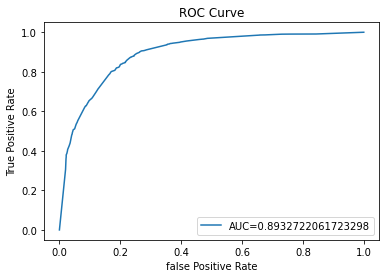

In [111]:
#ROC curve calculation

y_pred_proba= model.best_estimator_.predict_proba(X_test) [::,1]

false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)

auc= metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

Accuracy:  0.8486205402282248
Recall:  0.9133333333333333
Precision: 0.861996644295302
F1: 0.8869227449287872
CL Report:               precision    recall  f1-score   support

         0.0       0.82      0.73      0.77      2423
         1.0       0.86      0.91      0.89      4500

    accuracy                           0.85      6923
   macro avg       0.84      0.82      0.83      6923
weighted avg       0.85      0.85      0.85      6923



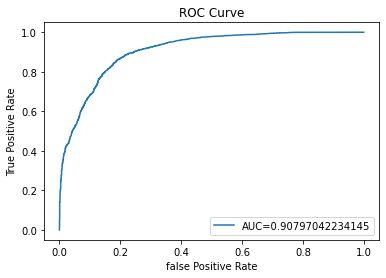

In [112]:
#training a random forest
my_random_seed = 45

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}

model = GridSearchCV(RandomForestClassifier(random_state=45), param_grid, cv=5)

model.fit(X_train, y_train)

#prediction
y_predict = model.best_estimator_.predict(X_test)

#evaluating the performance of the model
print('Accuracy: ',metrics.accuracy_score(y_test, y_predict))
print('Recall: ',metrics.recall_score(y_test, y_predict, zero_division=1))
print('Precision:',metrics.precision_score(y_test, y_predict, zero_division=1))
print('F1:',metrics.f1_score(y_test, y_predict, zero_division=1))
print('CL Report:',metrics.classification_report(y_test, y_predict, zero_division=1))

#ROC curve calculation

y_pred_proba= model.best_estimator_.predict_proba(X_test) [::,1]

false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)

auc= metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

In [114]:
#Start of feature testing (Car + CarDuration)

#splitting the dataset into features and target but removing a specific targeted feature.
target_col_feature1 = newDfOut.columns[-1]

X_all_feature1 = newDfOut[['Timer', 'Temperature', 'Condition', 'Light']]
Y_all_feature1 = newDfOut[target_col_feature1]

#split into training and testing sets
X_train_feature1, X_test_feature1, y_train_feature1, y_test_feature1 = train_test_split(X_all_feature1, Y_all_feature1, test_size=0.33, random_state=43)


#training a decision tree classifier
my_random_seed = 45

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}

model = GridSearchCV(RandomForestClassifier(random_state=45), param_grid, cv=5)

model.fit(X_train_feature1, y_train_feature1)
#random forest prediction
y_predict_feature1 = model.best_estimator_.predict(X_test_feature1)

In [115]:
#evaluating the performance of the model
print('Accuracy: ',metrics.accuracy_score(y_test_feature1, y_predict_feature1))
print('Recall: ',metrics.recall_score(y_test_feature1, y_predict_feature1, zero_division=1))
print('Precision:',metrics.precision_score(y_test_feature1, y_predict_feature1, zero_division=1))
print('F1:',metrics.f1_score(y_test_feature1, y_predict_feature1, zero_division=1))
print('CL Report:',metrics.classification_report(y_test_feature1, y_predict_feature1, zero_division=1))

Accuracy:  0.8249313881265348
Recall:  0.8866666666666667
Precision: 0.850383631713555
F1: 0.8681462140992167
CL Report:               precision    recall  f1-score   support

         0.0       0.77      0.71      0.74      2423
         1.0       0.85      0.89      0.87      4500

    accuracy                           0.82      6923
   macro avg       0.81      0.80      0.80      6923
weighted avg       0.82      0.82      0.82      6923



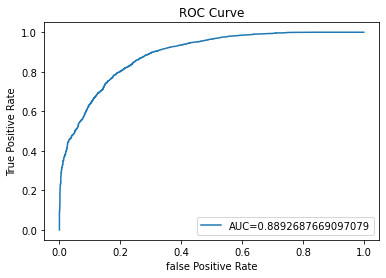

In [116]:
#ROC curve calculation

y_pred_proba_feature1= model.best_estimator_.predict_proba(X_test_feature1) [::,1]

false_positive_rate_feature1, true_positive_rate_feature1, _ = metrics.roc_curve(y_test_feature1, y_pred_proba_feature1)

auc= metrics.roc_auc_score(y_test_feature1, y_pred_proba_feature1)

plt.plot(false_positive_rate_feature1, true_positive_rate_feature1,label="AUC="+str(auc))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

In [117]:
#Start of feature testing (Condition + Temperature)

#splitting the dataset into features and target but removing a specific targeted feature.
target_col_feature1 = newDfOut.columns[-1]

X_all_feature1 = newDfOut[['Timer', 'Car', 'CarDuration', 'Light']]
Y_all_feature1 = newDfOut[target_col_feature1]

#split into training and testing sets
X_train_feature1, X_test_feature1, y_train_feature1, y_test_feature1 = train_test_split(X_all_feature1, Y_all_feature1, test_size=0.33, random_state=43)


#training a decision tree classifier
my_random_seed = 45

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}

model = GridSearchCV(RandomForestClassifier(random_state=45), param_grid, cv=5)

model.fit(X_train_feature1, y_train_feature1)
#decision tree prediction
y_predict_feature1 = model.best_estimator_.predict(X_test_feature1)

In [118]:
#evaluating the performance of the model
print('Accuracy: ',metrics.accuracy_score(y_test_feature1, y_predict_feature1))
print('Recall: ',metrics.recall_score(y_test_feature1, y_predict_feature1, zero_division=1))
print('Precision:',metrics.precision_score(y_test_feature1, y_predict_feature1, zero_division=1))
print('F1:',metrics.f1_score(y_test_feature1, y_predict_feature1, zero_division=1))
print('CL Report:',metrics.classification_report(y_test_feature1, y_predict_feature1, zero_division=1))

Accuracy:  0.8398093312147913
Recall:  0.8837777777777778
Precision: 0.8715757177295639
F1: 0.8776343374158666
CL Report:               precision    recall  f1-score   support

         0.0       0.78      0.76      0.77      2423
         1.0       0.87      0.88      0.88      4500

    accuracy                           0.84      6923
   macro avg       0.82      0.82      0.82      6923
weighted avg       0.84      0.84      0.84      6923



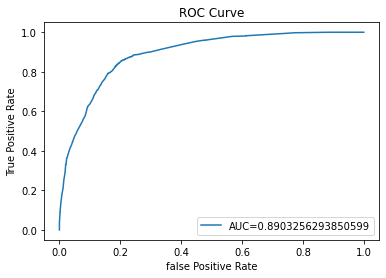

In [119]:
#ROC curve calculation

y_pred_proba_feature1= model.best_estimator_.predict_proba(X_test_feature1) [::,1]

false_positive_rate_feature1, true_positive_rate_feature1, _ = metrics.roc_curve(y_test_feature1, y_pred_proba_feature1)

auc= metrics.roc_auc_score(y_test_feature1, y_pred_proba_feature1)

plt.plot(false_positive_rate_feature1, true_positive_rate_feature1,label="AUC="+str(auc))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

In [120]:
#Start of feature testing (Timer)

#splitting the dataset into features and target but removing a specific targeted feature.
target_col_feature1 = newDfOut.columns[-1]

X_all_feature1 = newDfOut[['Temperature', 'Condition', 'Car', 'CarDuration', 'Light']]
Y_all_feature1 = newDfOut[target_col_feature1]

#split into training and testing sets
X_train_feature1, X_test_feature1, y_train_feature1, y_test_feature1 = train_test_split(X_all_feature1, Y_all_feature1, test_size=0.33, random_state=43)


#training a decision tree classifier
my_random_seed = 45

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}

model = GridSearchCV(RandomForestClassifier(random_state=45), param_grid, cv=5)

model.fit(X_train_feature1, y_train_feature1)
#decision tree prediction
y_predict_feature1 = model.best_estimator_.predict(X_test_feature1)

In [121]:
#evaluating the performance of the model
print('Accuracy: ',metrics.accuracy_score(y_test_feature1, y_predict_feature1))
print('Recall: ',metrics.recall_score(y_test_feature1, y_predict_feature1, zero_division=1))
print('Precision:',metrics.precision_score(y_test_feature1, y_predict_feature1, zero_division=1))
print('F1:',metrics.f1_score(y_test_feature1, y_predict_feature1, zero_division=1))
print('CL Report:',metrics.classification_report(y_test_feature1, y_predict_feature1, zero_division=1))

Accuracy:  0.8291203235591507
Recall:  0.8973333333333333
Precision: 0.8484975835259508
F1: 0.8722324225078302
CL Report:               precision    recall  f1-score   support

         0.0       0.79      0.70      0.74      2423
         1.0       0.85      0.90      0.87      4500

    accuracy                           0.83      6923
   macro avg       0.82      0.80      0.81      6923
weighted avg       0.83      0.83      0.83      6923



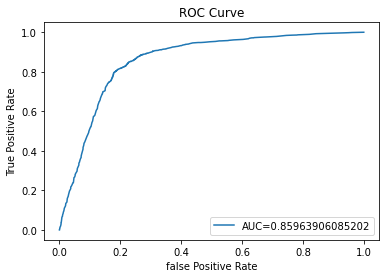

In [122]:
#ROC curve calculation

y_pred_proba_feature1= model.best_estimator_.predict_proba(X_test_feature1) [::,1]

false_positive_rate_feature1, true_positive_rate_feature1, _ = metrics.roc_curve(y_test_feature1, y_pred_proba_feature1)

auc= metrics.roc_auc_score(y_test_feature1, y_pred_proba_feature1)

plt.plot(false_positive_rate_feature1, true_positive_rate_feature1,label="AUC="+str(auc))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

In [127]:
#Start of feature testing (Timer + Light)

#splitting the dataset into features and target but removing a specific targeted feature.
target_col_feature1 = newDfOut.columns[-1]

X_all_feature1 = newDfOut[['Temperature', 'Condition', 'Car', 'CarDuration']]
Y_all_feature1 = newDfOut[target_col_feature1]

#split into training and testing sets
X_train_feature1, X_test_feature1, y_train_feature1, y_test_feature1 = train_test_split(X_all_feature1, Y_all_feature1, test_size=0.33, random_state=43)


#training a decision tree classifier
my_random_seed = 45

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}

model = GridSearchCV(RandomForestClassifier(random_state=45), param_grid, cv=5)

model.fit(X_train_feature1, y_train_feature1)
#decision tree prediction
y_predict_feature1 = model.best_estimator_.predict(X_test_feature1)

In [129]:
#evaluating the performance of the model
print('Accuracy: ',metrics.accuracy_score(y_test_feature1, y_predict_feature1))
print('Recall: ',metrics.recall_score(y_test_feature1, y_predict_feature1, zero_division=1))
print('Precision:',metrics.precision_score(y_test_feature1, y_predict_feature1, zero_division=1))
print('F1:',metrics.f1_score(y_test_feature1, y_predict_feature1, zero_division=1))
print('CL Report:',metrics.classification_report(y_test_feature1, y_predict_feature1, zero_division=1))

Accuracy:  0.6728296981077567
Recall:  0.9615555555555556
Precision: 0.6740925377784701
F1: 0.7925634215587508
CL Report:               precision    recall  f1-score   support

         0.0       0.66      0.14      0.23      2423
         1.0       0.67      0.96      0.79      4500

    accuracy                           0.67      6923
   macro avg       0.67      0.55      0.51      6923
weighted avg       0.67      0.67      0.59      6923



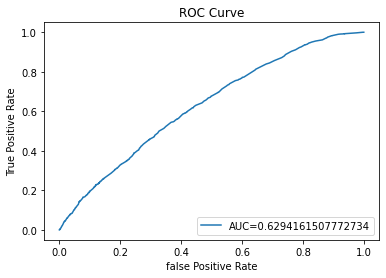

In [128]:
#ROC curve calculation

y_pred_proba_feature1= model.best_estimator_.predict_proba(X_test_feature1) [::,1]

false_positive_rate_feature1, true_positive_rate_feature1, _ = metrics.roc_curve(y_test_feature1, y_pred_proba_feature1)

auc= metrics.roc_auc_score(y_test_feature1, y_pred_proba_feature1)

plt.plot(false_positive_rate_feature1, true_positive_rate_feature1,label="AUC="+str(auc))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

In [131]:
#Start of feature testing (Light)

#splitting the dataset into features and target but removing a specific targeted feature.
target_col_feature1 = newDfOut.columns[-1]

X_all_feature1 = newDfOut[['Temperature', 'Condition', 'Car', 'CarDuration', 'Timer']]
Y_all_feature1 = newDfOut[target_col_feature1]

#split into training and testing sets
X_train_feature1, X_test_feature1, y_train_feature1, y_test_feature1 = train_test_split(X_all_feature1, Y_all_feature1, test_size=0.33, random_state=43)


#training a decision tree classifier
my_random_seed = 45

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}

model = GridSearchCV(RandomForestClassifier(random_state=45), param_grid, cv=5)

model.fit(X_train_feature1, y_train_feature1)
#decision tree prediction
y_predict_feature1 = model.best_estimator_.predict(X_test_feature1)

In [132]:
#evaluating the performance of the model
print('Accuracy: ',metrics.accuracy_score(y_test_feature1, y_predict_feature1))
print('Recall: ',metrics.recall_score(y_test_feature1, y_predict_feature1, zero_division=1))
print('Precision:',metrics.precision_score(y_test_feature1, y_predict_feature1, zero_division=1))
print('F1:',metrics.f1_score(y_test_feature1, y_predict_feature1, zero_division=1))
print('CL Report:',metrics.classification_report(y_test_feature1, y_predict_feature1, zero_division=1))

Accuracy:  0.6901632240358226
Recall:  0.8346666666666667
Precision: 0.7283304246655032
F1: 0.7778813296054675
CL Report:               precision    recall  f1-score   support

         0.0       0.58      0.42      0.49      2423
         1.0       0.73      0.83      0.78      4500

    accuracy                           0.69      6923
   macro avg       0.65      0.63      0.63      6923
weighted avg       0.68      0.69      0.68      6923



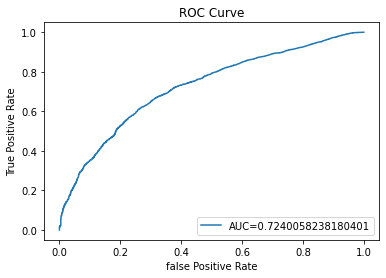

In [133]:
#ROC curve calculation

y_pred_proba_feature1= model.best_estimator_.predict_proba(X_test_feature1) [::,1]

false_positive_rate_feature1, true_positive_rate_feature1, _ = metrics.roc_curve(y_test_feature1, y_pred_proba_feature1)

auc= metrics.roc_auc_score(y_test_feature1, y_pred_proba_feature1)

plt.plot(false_positive_rate_feature1, true_positive_rate_feature1,label="AUC="+str(auc))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)